In [2]:
import torch
print(torch.__version__)  # Check PyTorch version

# Replace {torch_version} with the output from above, e.g., 1.9.0+cu102
!pip install torch-scatter -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-sparse -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-cluster -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-spline-conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
!pip install torch-geometric


2.5.1+cu121
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.9/10.9 MB 87.3 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 67.2 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 45.8 MB/s eta 0:00:00
Looking in links: https://data.pyg.org/whl/torch-2.5.1+cu121.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 991.6/991.6 kB 35.8 MB/s eta 0:00:00
  Using cached torch_geometric-2.6.1-py3-none-any.whl.metadata (63 kB)
Using cached torch_geometric-2.6.1-py3-none-any.whl (1.1 MB)


In [3]:
import torch
import torch.nn.functional as F
from torch_geometric.datasets import Planetoid
from torch_geometric.nn import GCNConv
from torch_geometric.utils import train_test_split_edges, negative_sampling
import matplotlib.pyplot as plt
import networkx as nx
from sklearn.metrics import roc_auc_score, average_precision_score


In [4]:
dataset = Planetoid(root='/tmp/Cora', name='Cora')
data = dataset[0]


Processing...
Done!


In [5]:
print(f'Dataset: {dataset}')
print('======================')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features: {dataset.num_node_features}')
print(f'Number of classes: {dataset.num_classes}')

print('\nData details:')
print('======================')
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')
print(f'Training nodes: {data.train_mask.sum()}')
print(f'Validation nodes: {data.val_mask.sum()}')
print(f'Test nodes: {data.test_mask.sum()}')
print(f'Contains isolated nodes: {data.contains_isolated_nodes()}')
print(f'Contains self-loops: {data.contains_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')


Dataset: Cora()
Number of graphs: 1
Number of features: 1433
Number of classes: 7

Data details:
Number of nodes: 2708
Number of edges: 10556
Average node degree: 3.90
Training nodes: 140
Validation nodes: 500
Test nodes: 1000
Contains isolated nodes: False
Contains self-loops: False
Is undirected: True


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_isolated_nodes' is deprecated, use 'has_isolated_nodes' instead
  warnings.warn(out)
/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'contains_self_loops' is deprecated, use 'has_self_loops' instead
  warnings.warn(out)


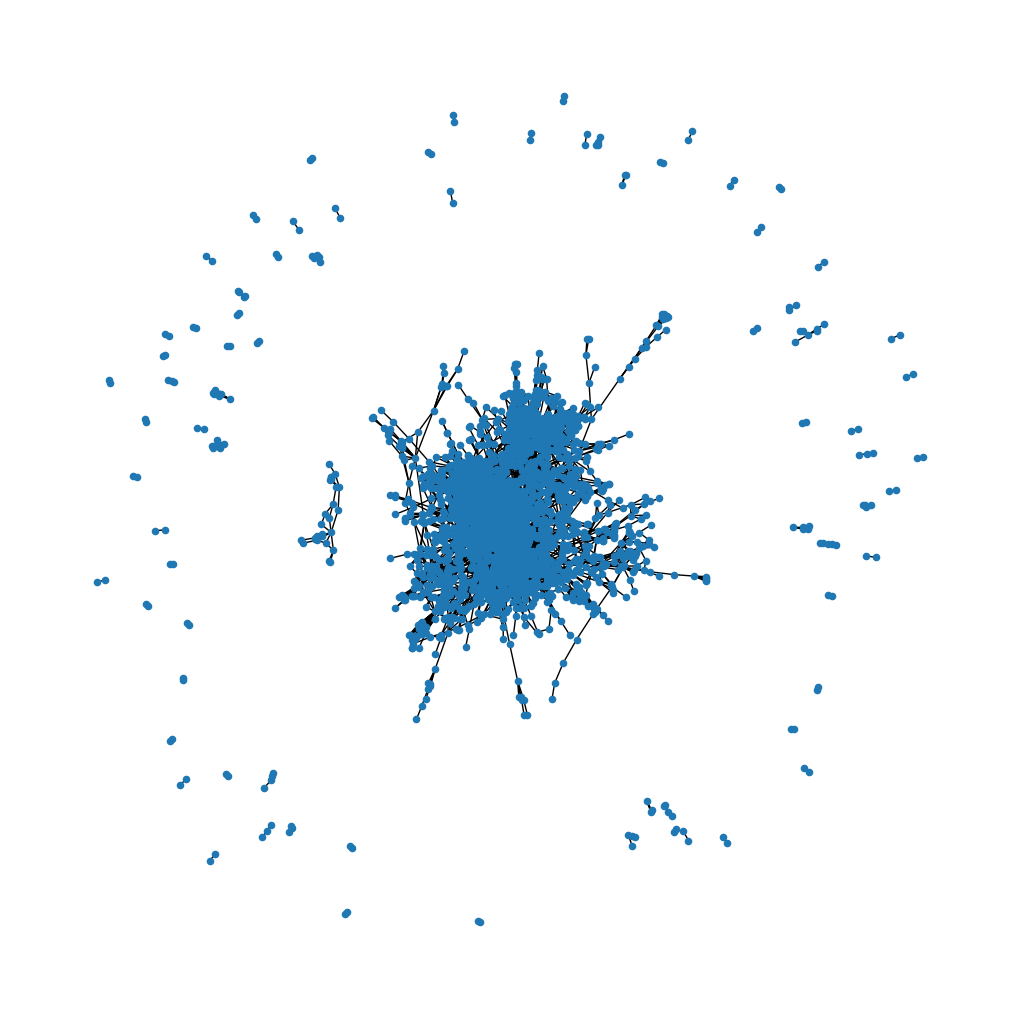

In [6]:
edge_index = data.edge_index
G = nx.Graph()
edges = edge_index.t().tolist()
G.add_edges_from(edges)

plt.figure(figsize=(10, 10))
nx.draw(G, node_size=20)
plt.show()


In [7]:
# Convert the data for link prediction
data = train_test_split_edges(data)


/usr/local/lib/python3.10/dist-packages/torch_geometric/deprecation.py:26: UserWarning: 'train_test_split_edges' is deprecated, use 'transforms.RandomLinkSplit' instead
  warnings.warn(out)


In [8]:
class GCNEncoder(torch.nn.Module):
    def __init__(self, in_channels, out_channels):
        super(GCNEncoder, self).__init__()
        self.conv1 = GCNConv(in_channels, 2 * out_channels)
        self.conv2 = GCNConv(2 * out_channels, out_channels)

    def forward(self, x, edge_index):
        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        return x


In [9]:
class LinkPredictor(torch.nn.Module):
    def __init__(self, in_channels):
        super(LinkPredictor, self).__init__()
        self.encoder = GCNEncoder(dataset.num_node_features, in_channels)

    def decode(self, z, edge_index):
        # Compute dot product between node embeddings
        return (z[edge_index[0]] * z[edge_index[1]]).sum(dim=1)

    def forward(self, x, edge_index, pos_edge_index, neg_edge_index):
        z = self.encoder(x, edge_index)
        # Positive logits
        pos_logits = self.decode(z, pos_edge_index)
        # Negative logits
        neg_logits = self.decode(z, neg_edge_index)
        logits = torch.cat([pos_logits, neg_logits], dim=0)
        # Labels: 1 for positive edges, 0 for negative edges
        pos_labels = torch.ones(pos_edge_index.size(1), device=x.device)
        neg_labels = torch.zeros(neg_edge_index.size(1), device=x.device)
        labels = torch.cat([pos_labels, neg_labels], dim=0)
        return logits, labels


In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = LinkPredictor(in_channels=64).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)


In [11]:
def train():
    model.train()
    optimizer.zero_grad()
    # Sample negative edges
    neg_edge_index = negative_sampling(
        edge_index=data.train_pos_edge_index,
        num_nodes=data.num_nodes,
        num_neg_samples=data.train_pos_edge_index.size(1),
    )
    logits, labels = model(data.x, data.train_pos_edge_index, data.train_pos_edge_index, neg_edge_index)
    loss = F.binary_cross_entropy_with_logits(logits, labels)
    loss.backward()
    optimizer.step()
    return loss.item()


In [12]:
@torch.no_grad()
def test(pos_edge_index, neg_edge_index):
    model.eval()
    z = model.encoder(data.x, data.train_pos_edge_index)
    pos_logits = model.decode(z, pos_edge_index)
    neg_logits = model.decode(z, neg_edge_index)
    logits = torch.cat([pos_logits, neg_logits], dim=0)
    labels = torch.cat([
        torch.ones(pos_logits.size(0), device=device),
        torch.zeros(neg_logits.size(0), device=device)
    ])
    pred = logits.sigmoid()
    auc = roc_auc_score(labels.cpu(), pred.cpu())
    ap = average_precision_score(labels.cpu(), pred.cpu())
    return auc, ap


In [13]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.6556, Val AUC: 0.7988, Val AP: 0.8143
Epoch 020, Loss: 0.5394, Val AUC: 0.8643, Val AP: 0.8668
Epoch 030, Loss: 0.4780, Val AUC: 0.8957, Val AP: 0.8972
Epoch 040, Loss: 0.4501, Val AUC: 0.9078, Val AP: 0.9070
Epoch 050, Loss: 0.4334, Val AUC: 0.9165, Val AP: 0.9154
Epoch 060, Loss: 0.4242, Val AUC: 0.9197, Val AP: 0.9192
Epoch 070, Loss: 0.4181, Val AUC: 0.9152, Val AP: 0.9177
Epoch 080, Loss: 0.4131, Val AUC: 0.9090, Val AP: 0.9157
Epoch 090, Loss: 0.4068, Val AUC: 0.9046, Val AP: 0.9139
Epoch 100, Loss: 0.4051, Val AUC: 0.9021, Val AP: 0.9120


In [14]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.4041, Val AUC: 0.9058, Val AP: 0.9156
Epoch 020, Loss: 0.4030, Val AUC: 0.9058, Val AP: 0.9165
Epoch 030, Loss: 0.4010, Val AUC: 0.9047, Val AP: 0.9168
Epoch 040, Loss: 0.4009, Val AUC: 0.9014, Val AP: 0.9154
Epoch 050, Loss: 0.3942, Val AUC: 0.9014, Val AP: 0.9159
Epoch 060, Loss: 0.3968, Val AUC: 0.8982, Val AP: 0.9122
Epoch 070, Loss: 0.3972, Val AUC: 0.8996, Val AP: 0.9119
Epoch 080, Loss: 0.3940, Val AUC: 0.9033, Val AP: 0.9164
Epoch 090, Loss: 0.3927, Val AUC: 0.9035, Val AP: 0.9184
Epoch 100, Loss: 0.3935, Val AUC: 0.9042, Val AP: 0.9185


In [15]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.3907, Val AUC: 0.9021, Val AP: 0.9157
Epoch 020, Loss: 0.3903, Val AUC: 0.8986, Val AP: 0.9128
Epoch 030, Loss: 0.3906, Val AUC: 0.8982, Val AP: 0.9100
Epoch 040, Loss: 0.3916, Val AUC: 0.8917, Val AP: 0.9078
Epoch 050, Loss: 0.3900, Val AUC: 0.8919, Val AP: 0.9078
Epoch 060, Loss: 0.3864, Val AUC: 0.8940, Val AP: 0.9100
Epoch 070, Loss: 0.3879, Val AUC: 0.8879, Val AP: 0.9074
Epoch 080, Loss: 0.3859, Val AUC: 0.8884, Val AP: 0.9074
Epoch 090, Loss: 0.3843, Val AUC: 0.8903, Val AP: 0.9054
Epoch 100, Loss: 0.3919, Val AUC: 0.8891, Val AP: 0.9038


In [16]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.3860, Val AUC: 0.8905, Val AP: 0.9066
Epoch 020, Loss: 0.3849, Val AUC: 0.8870, Val AP: 0.9051
Epoch 030, Loss: 0.3870, Val AUC: 0.8859, Val AP: 0.9049
Epoch 040, Loss: 0.3850, Val AUC: 0.8787, Val AP: 0.9022
Epoch 050, Loss: 0.3867, Val AUC: 0.8810, Val AP: 0.9034
Epoch 060, Loss: 0.3862, Val AUC: 0.8716, Val AP: 0.8971
Epoch 070, Loss: 0.3856, Val AUC: 0.8672, Val AP: 0.8960
Epoch 080, Loss: 0.3836, Val AUC: 0.8658, Val AP: 0.8959
Epoch 090, Loss: 0.3864, Val AUC: 0.8645, Val AP: 0.8945
Epoch 100, Loss: 0.3835, Val AUC: 0.8663, Val AP: 0.8945


In [17]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.3799, Val AUC: 0.8625, Val AP: 0.8915
Epoch 020, Loss: 0.3835, Val AUC: 0.8568, Val AP: 0.8891
Epoch 030, Loss: 0.3812, Val AUC: 0.8585, Val AP: 0.8911
Epoch 040, Loss: 0.3872, Val AUC: 0.8591, Val AP: 0.8905
Epoch 050, Loss: 0.3851, Val AUC: 0.8636, Val AP: 0.8915
Epoch 060, Loss: 0.3783, Val AUC: 0.8589, Val AP: 0.8892
Epoch 070, Loss: 0.3805, Val AUC: 0.8575, Val AP: 0.8895
Epoch 080, Loss: 0.3816, Val AUC: 0.8553, Val AP: 0.8850
Epoch 090, Loss: 0.3824, Val AUC: 0.8556, Val AP: 0.8877
Epoch 100, Loss: 0.3779, Val AUC: 0.8590, Val AP: 0.8905


In [18]:
for epoch in range(1, 101):
    loss = train()
    val_auc, val_ap = test(data.val_pos_edge_index, data.val_neg_edge_index)
    if epoch % 10 == 0:
        print(f'Epoch {epoch:03d}, Loss: {loss:.4f}, Val AUC: {val_auc:.4f}, Val AP: {val_ap:.4f}')


Epoch 010, Loss: 0.3859, Val AUC: 0.8577, Val AP: 0.8872
Epoch 020, Loss: 0.3784, Val AUC: 0.8573, Val AP: 0.8877
Epoch 030, Loss: 0.3765, Val AUC: 0.8597, Val AP: 0.8911
Epoch 040, Loss: 0.3787, Val AUC: 0.8583, Val AP: 0.8903
Epoch 050, Loss: 0.3820, Val AUC: 0.8563, Val AP: 0.8891
Epoch 060, Loss: 0.3773, Val AUC: 0.8474, Val AP: 0.8838
Epoch 070, Loss: 0.3779, Val AUC: 0.8454, Val AP: 0.8824
Epoch 080, Loss: 0.3802, Val AUC: 0.8457, Val AP: 0.8835
Epoch 090, Loss: 0.3783, Val AUC: 0.8485, Val AP: 0.8841
Epoch 100, Loss: 0.3794, Val AUC: 0.8523, Val AP: 0.8860


In [19]:
test_auc, test_ap = test(data.test_pos_edge_index, data.test_neg_edge_index)
print(f'Test AUC: {test_auc:.4f}, Test AP: {test_ap:.4f}')


Test AUC: 0.8955, Test AP: 0.9089


In [20]:
model.eval()
z = model.encoder(data.x, data.train_pos_edge_index)


In [21]:
# Combine test positive and negative edges
edge_index = torch.cat([data.test_pos_edge_index, data.test_neg_edge_index], dim=-1)
logits = model.decode(z, edge_index)
probs = logits.sigmoid()


In [22]:
# Get top K predicted edges
K = 50
_, indices = torch.topk(probs, K)
top_edge_index = edge_index[:, indices]


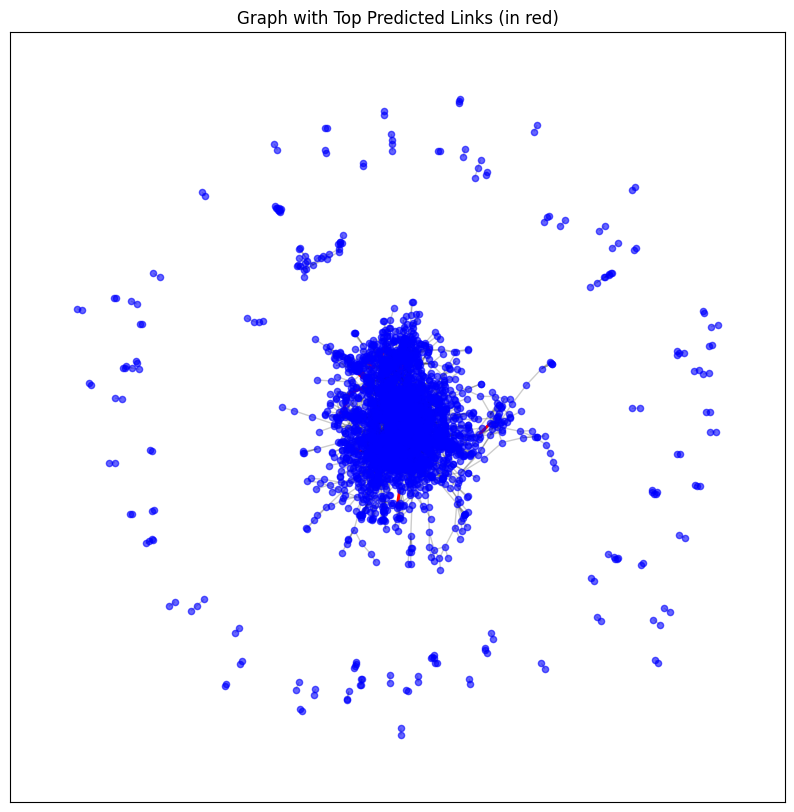

In [23]:
# Convert to NetworkX graph
G_pred = nx.Graph()
G_pred.add_edges_from(top_edge_index.cpu().numpy().T)

plt.figure(figsize=(10, 10))
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_size=20, node_color='blue', alpha=0.6)
nx.draw_networkx_edges(G, pos, alpha=0.2)
nx.draw_networkx_edges(G_pred, pos, edge_color='red', width=2)
plt.title('Graph with Top Predicted Links (in red)')
plt.show()


In [24]:
torch.save(model.state_dict(), 'link_prediction_model.pth')
print("Model saved to 'link_prediction_model.pth'")


Model saved to 'link_prediction_model.pth'
